In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
url = "https://raw.githubusercontent.com/arimitramaiti/datasets/master/Classification/heart.csv"
dataset = pd.read_csv(url, error_bad_lines=False, header=0, index_col=None)
dataset.head()
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


# One hot encoding

 - __Perform pandas one hot encoding through get_dummies() method and convert categorical attributes to dummy variables__
 - __Inititally refraining from drop_first=True arguement so that dropped features are not ignored from feature selection__

In [3]:
sex_dummy = pd.get_dummies(dataset.sex)
sex_dummy.columns = ["Male", "Female"]

cp_dummy = pd.get_dummies(dataset.cp)
cp_dummy.columns = ["cp0", "cp1", "cp2", "cp3"]

fbs_dummy = pd.get_dummies(dataset.fbs)
fbs_dummy.columns = ["fbs0", "fbs1"]

restecg_dummy = pd.get_dummies(dataset.restecg)
restecg_dummy.columns = ["restecg0", "restecg1", "restecg2"]

exang_dummy = pd.get_dummies(dataset.exang)
exang_dummy.columns = ["exang0", "exang1"]

slope_dummy = pd.get_dummies(dataset.slope)
slope_dummy.columns = ["slope0", "slope1", "slope2"]

ca_dummy = pd.get_dummies(dataset.ca)
ca_dummy.columns = ["ca0", "ca1", "ca2", "ca3", "ca4"]

thal_dummy = pd.get_dummies(dataset.thal)
thal_dummy.columns = ["thal0", "thal1", "thal2", "thal3"]

tmp = dataset[["target", "age", "trestbps", "chol", "thalach", "oldpeak"]]

onehot_data = pd.concat([tmp, sex_dummy, cp_dummy, fbs_dummy, restecg_dummy, exang_dummy, slope_dummy, ca_dummy, thal_dummy],
                       axis=1)

# Import required modules

 - __Import modules for train test split and feature selection__

In [85]:
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif, SelectKBest, SelectPercentile, chi2, f_classif
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

# Split into Train & Test

 - __Create separate datasets for independent and dependent attributes__
 - __Create 80% rows in training and 20% in testing using stratified sampling__

In [86]:
X = onehot_data.drop('target', axis=1)
y = onehot_data['target']
X.shape, y.shape

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(242, 30) (61, 30) (242,) (61,)


# Univariate Filter Method : Mutual Information for Classification

 - __Use mutual_info_classif() function using independent and dependent training data__
 - __measures the dependency between the variables__
 - __It is equal to zero if and only if two random variables are independent, and higher values mean higher dependency__
 - __Transfer the output into a pandas series and assign index as column values for identification__
 - __Sort the mutual info dataset with highest score at the top__
 - __Plot the scores to see which attributes are not adding any information__

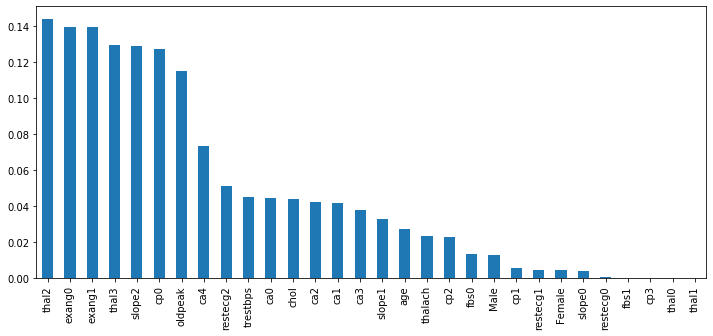

In [28]:
mi = mutual_info_classif(X_train, y_train)
mi = pd.Series(mi, index=X_train.columns)
mi.sort_values(ascending=False, inplace=True)
mi.plot.bar(figsize=(12,5))

 - __We may use SelectPercentile() or SelectKBest() filtering method to select top attributes based on mutual info score__
 - __Here we select top 10 attributes__
 - __get_support() is the method to see which columns are selected as top contributors__

In [19]:
# sel = SelectPercentile(mutual_info_classif, 25).fit(X_train, y_train)
sel = SelectKBest(mutual_info_classif, 10).fit(X_train, y_train)
X_train.columns[sel.get_support()]
X_test.columns[sel.get_support()]

X_train_mi = sel.transform(X_train)
X_test_mi = sel.transform(X_test)

X_train_mi.shape, X_test_mi.shape

((242, 10), (61, 10))

# Univariate Filter Method : Chi Square and Fischer Score

 - __Using chi square method we can select those features which at the far end of the graph below__
 - __The Null hypothesis is that there is NO association between target and independent variables one at a time__
 - __The Alternate hypothesis says there is evidence to suggest there is an association between the two variables__

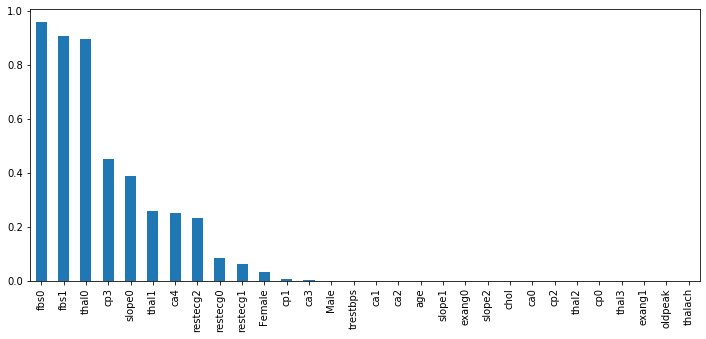

In [29]:
f_score = chi2(X_train, y_train)
p_values = pd.Series(f_score[1], index=X_train.columns)
p_values.sort_values(ascending=False, inplace=True)
p_values.plot.bar(figsize=(12,5))

 - __SelectKBest() filtering method again helps in selecting k best features based on chi square__

In [31]:
sel = SelectKBest(chi2, 10).fit(X_train, y_train)
X_train.columns[sel.get_support()]
X_test.columns[sel.get_support()]

X_train_chi = sel.transform(X_train)
X_test_chi = sel.transform(X_test)

X_train_chi.shape, X_test_chi.shape

((242, 10), (61, 10))

# Univariate Filter Method : Anova f score

 - __f_classif is done on a feature by feature basis__
 - __calculates anova f-value between feature for classification tasks__

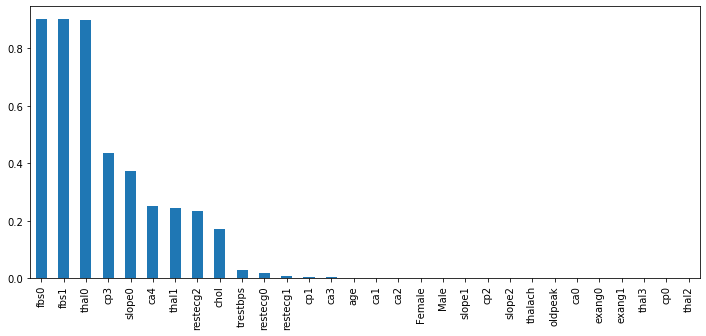

In [34]:
anova_f = f_classif(X_train, y_train)
p_values = pd.Series(anova_f[1], index=X_train.columns)
p_values.sort_values(ascending=False, inplace=True)
p_values.plot.bar(figsize=(12,5))

In [35]:
sel = SelectKBest(f_classif, 10).fit(X_train, y_train)
X_train.columns[sel.get_support()]
X_test.columns[sel.get_support()]

X_train_chi = sel.transform(X_train)
X_test_chi = sel.transform(X_test)

X_train_chi.shape, X_test_chi.shape

((242, 10), (61, 10))

# Wrapper : Sequential FORWARD Feature Selection

 - __Start with a null model and then start fitting the model with each individual feature one at a time and select the feature with the minimum p-value__
 - __Now fit a model with two features by trying combinations of the earlier selected feature with all other remaining features. Continue the minimum p-value selection criteria__
 - __Repeat this process until we have a set of selected features with a p-value of individual feature less than the significance level__

In [73]:
sfs = SFS(RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1), 
          k_features=(1, X_train.shape[1]), 
          forward=True, 
          floating=False, 
          verbose=2, 
          scoring='accuracy', 
          cv = 4, 
          n_jobs=-1).fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   21.3s finished

[2020-05-13 14:47:22] Features: 1/30 -- score: 0.76051912568306[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  29 out of  29 | elapsed:   18.6s finished

[2020-05-13 14:47:40] Features: 2/30 -- score: 0.7645491803278688[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 out of  28 | elapsed:   17.5s finished

[2020-05-13 14:47:58] Features: 3/30 -- score: 0.7810109289617486[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:   18.0s finished

[2020-05-13 14:48:16] Features: 4/30 -- score: 0.8345628415300547[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 out of  26 | elapsed:   17.4s finished

[2

 - __k_score_ gives the score of the model with best set of features__
 - __k_feature_names_ gives the tuple of feature names selected best__
 - __k_feature_idx_ gives the tuple of feature index based on train data__
 - __We need to convert the tuple into list so that that best features can selected from the entire list of training/test data__
 - __We finally use the transform() method to transform our train/test data__

In [74]:
sfs.k_score_
sfs.k_feature_names_
sfs.k_feature_idx_

X_train[list(sfs.k_feature_names_)]
X_test[list(sfs.k_feature_names_)]

X_train_sfsF = sfs.transform(X_train)
X_test_sfsF = sfs.transform(X_test)

X_train_sfsF.shape, X_test_sfsF.shape

((242, 16), (61, 16))

# Wrapper : Sequential BACKWARD Feature Selection

 - __We start with all the independent variables and then remove the insignificant feature with highest p-value__
 - __This process repeats again and again until we have the final set of significant features__

In [76]:
sfs = SFS(RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1), 
          k_features=(1, X_train.shape[1]), 
          forward=False, 
          floating=False, 
          verbose=2, 
          scoring='accuracy', 
          cv = 4, 
          n_jobs=-1).fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   19.6s finished

[2020-05-13 14:56:18] Features: 29/1 -- score: 0.8468579234972677[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  29 out of  29 | elapsed:   20.0s finished

[2020-05-13 14:56:38] Features: 28/1 -- score: 0.8469262295081967[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 out of  28 | elapsed:   18.3s finished

[2020-05-13 14:56:56] Features: 27/1 -- score: 0.8551912568306012[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:   18.2s finished

[2020-05-13 14:57:14] Features: 26/1 -- score: 0.8511612021857924[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 out of  26 | elapsed:   16.9s finished



In [77]:
sfs.k_score_
sfs.k_feature_names_
sfs.k_feature_idx_

X_train[list(sfs.k_feature_names_)]
X_test[list(sfs.k_feature_names_)]

X_train_sfsB = sfs.transform(X_train)
X_test_sfsB = sfs.transform(X_test)

X_train_sfsB.shape, X_test_sfsB.shape

((242, 16), (61, 16))

 - __plot_sfs() allows to plot visual inorder to select best number of features with highest accuracy__

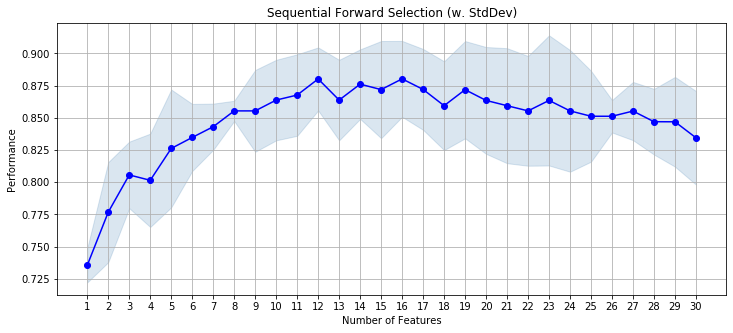

In [79]:
plot_sfs(sfs.get_metric_dict(),
                kind='std_dev',
                figsize=(12, 5))

plt.title('Sequential Forward Selection (w. StdDev)')
plt.grid()
plt.show()

# Wrapper : Exhaustive Feature Selection

 - __Wrapper approach for brute-force evaluation of feature subsets__
 - __The best subset is selected by optimizing a specified performance metric given an arbitrary regressor or classifier__
 - __Extremely slow relative to sfs and computer intensive__
 - Link for further study: http://rasbt.github.io/mlxtend/user_guide/feature_selection/ExhaustiveFeatureSelector/

In [84]:
efs = EFS(RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1), 
          min_features=10, 
          max_features=16,
          scoring='accuracy', 
          cv = None, 
          n_jobs=-1).fit(X_train, y_train)

In [ ]:
efs.k_score_
efs.k_feature_names_
efs.k_feature_idx_

X_train[list(efs.k_feature_names_)]
X_test[list(efs.k_feature_names_)]

X_train_EFS = efs.transform(X_train)
X_test_EFS = efs.transform(X_test)

X_train_EFS.shape, X_test_EFS.shape

In [ ]:
plot_sfs(efs.get_metric_dict(),
                kind='std_dev',
                figsize=(12, 5))

plt.title('Sequential Forward Selection (w. StdDev)')
plt.grid()
plt.show()

# Embed : Recursive Feature Extraction with Cross Validation

 - __RFE is a kind of backward selection of the predictors__
 - __This technique begins by building a model on the entire set of predictors and computing an importance score for each predictor__
 - __The least important predictor(s) are then removed, the model is re-built, and importance scores are computed again__

In [87]:
rfe = RFECV(RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1), 
          step=1, 
          cv=StratifiedKFold(10),
          scoring='accuracy', 
          n_jobs=-1).fit(X_train, y_train)

In [88]:
rfe.n_features_

26

 - __Plot the accuracy for each set of features, here we see the accuracy peak is mostly at 26 features__

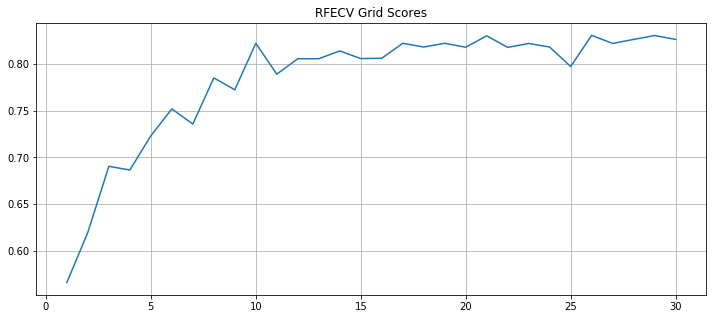

In [93]:
fig = plt.figure(figsize=(12, 5))
plt.plot(range(1, len(rfe.grid_scores_) +1), rfe.grid_scores_)
plt.title('RFECV Grid Scores')
plt.grid()
plt.show()

 - __Select the important features__

In [112]:
X_train.drop(X_train.columns[np.where(rfe.support_ == False)[0]], axis=1, inplace=True)
X_test.drop(X_test.columns[np.where(rfe.support_ == False)[0]], axis=1, inplace=True)

X_train_ref = pd.DataFrame(X_train)
X_test_rfe = pd.DataFrame(X_test)
X_train_rfe.shape, X_test_rfe.shape

 - __Plot feature importances__

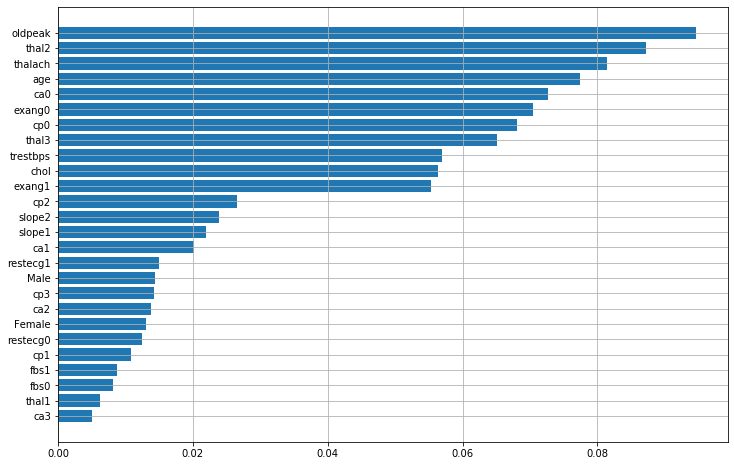

In [124]:
imp = pd.DataFrame()
imp['features'] = X_train.columns
imp['score'] = rfe.estimator_.feature_importances_
imp = imp.sort_values(by='score', ascending=True)
imp

fig = plt.figure(figsize=(12, 8))
plt.barh(imp["features"], width=imp["score"], height=0.8)
plt.grid()
plt.show()